In [1]:
IN_PATH = 'data/'


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import norm

# Random Seed at file level
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

predictors_droped = ['points']

X_train, X_test, y_train, y_test = pd.read_csv(f'{IN_PATH}X_train.csv'), pd.read_csv(f'{IN_PATH}X_test.csv'), pd.read_csv(f'{IN_PATH}y_train.csv'), pd.read_csv(f'{IN_PATH}y_test.csv')
X_train = X_train.drop(columns=predictors_droped)
X_test = X_test.drop(columns=predictors_droped)

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

clf = GaussianNB() # Has parameters var_smoothing=1e-09 by default
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[206  18]
 [ 20 156]]

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.92      0.92       224
        True       0.90      0.89      0.89       176

    accuracy                           0.91       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.91      0.90       400



### Parameter testing

In [2]:

for var_smoothing in [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]:
    clf = GaussianNB(var_smoothing=var_smoothing)
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)

    print(f"Var Smoothing: {var_smoothing}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))



Var Smoothing: 1e-11
Confusion Matrix:
[[206  18]
 [ 20 156]]

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.92      0.92       224
        True       0.90      0.89      0.89       176

    accuracy                           0.91       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.91      0.90       400

Var Smoothing: 1e-10
Confusion Matrix:
[[206  18]
 [ 20 156]]

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.92      0.92       224
        True       0.90      0.89      0.89       176

    accuracy                           0.91       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.91      0.90       400

Var Smoothing: 1e-09
Confusion Matrix:
[[206  18]
 [ 20 156]]

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.92

Equivalent results obtained for different values of the parameter. Lets use the default value.

Final model
Confusion Matrix:
[[206  18]
 [ 20 156]]

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.92      0.92       224
        True       0.90      0.89      0.89       176

    accuracy                           0.91       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.91      0.90       400



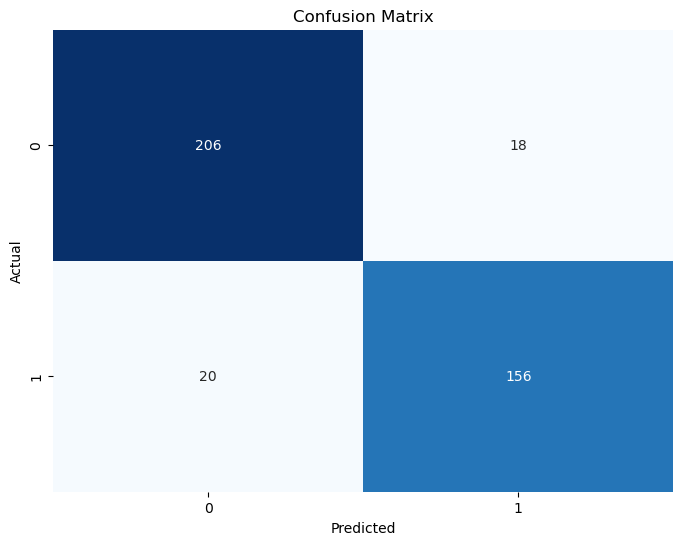

In [12]:
# Use default var_smoothing for further analysis
clf = GaussianNB()
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)

print("Final model")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [4]:

mean_features_y1 = clf.theta_[0]
mean_features_y2 = clf.theta_[1]

var_features_y1 = clf.var_[0]
var_features_y2 = clf.var_[1]

print(clf.theta_.shape)
print("Mean feature values for class 1:")
print(mean_features_y1)
print("\nMean feature values for class 2:")
print(mean_features_y2)

# Difference in means
mean_diff = (mean_features_y2 - mean_features_y1)
print("\nDifference in mean feature values between class 2 and class 1:")
print(mean_diff)
#print(np.argmax(np.abs(mean_diff)))  # Index of feature with largest difference



(2, 4)
Mean feature values for class 1:
[8.25279565e+04 4.71007804e+02 2.72099175e+04 1.92664437e+01]

Mean feature values for class 2:
[1.00179394e+05 7.02167852e+02 2.25592745e+04 2.20597440e+01]

Difference in mean feature values between class 2 and class 1:
[ 1.76514375e+04  2.31160048e+02 -4.65064297e+03  2.79330025e+00]


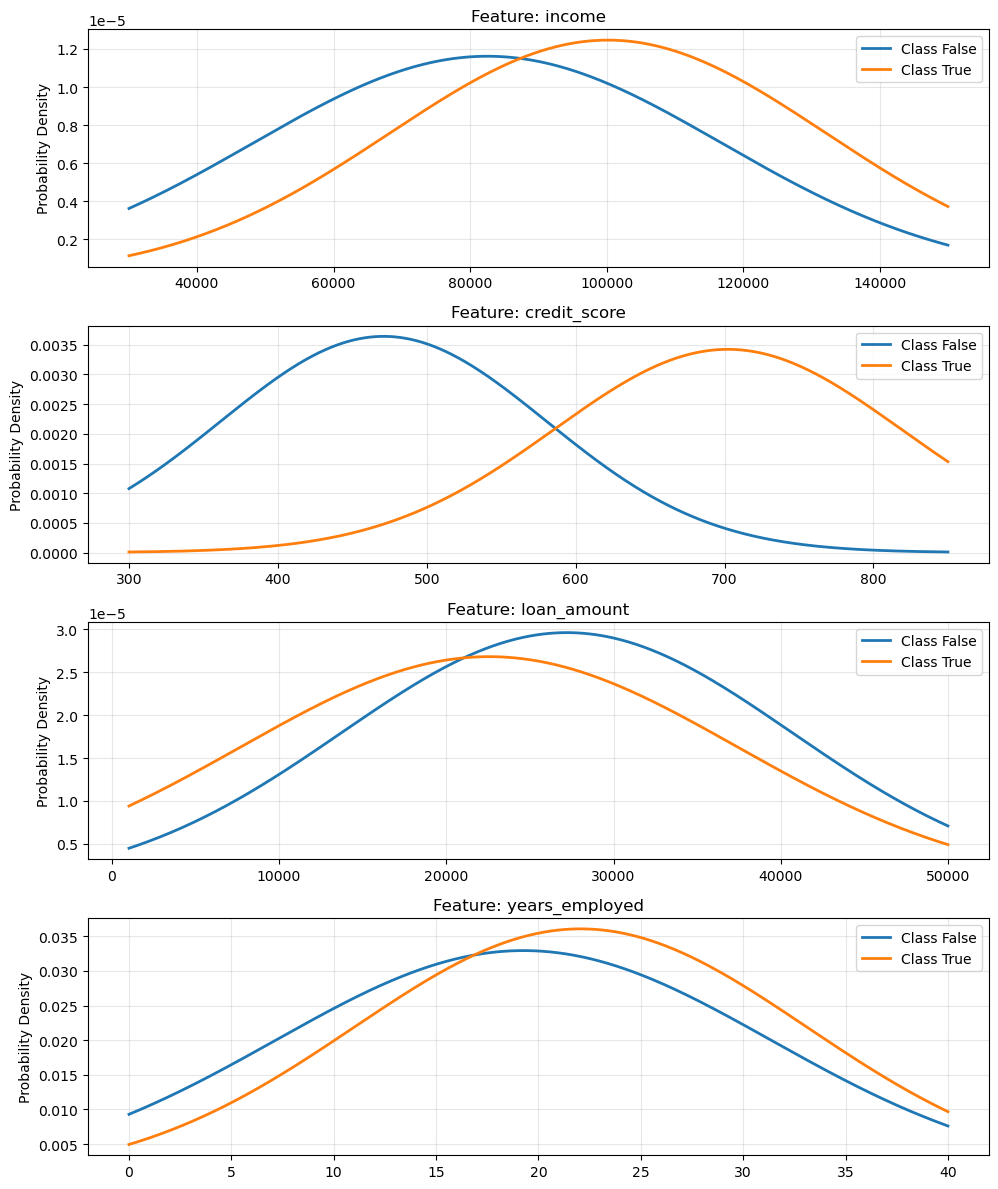

In [5]:


def plot_feature_posteriors(clf, feature_names, n_features_to_plot=6):
    """

    Plot posterior probability distributions for features
    
    Parameters:
    clf: Your fitted GaussianNB classifier
    feature_names: List of feature names
    n_features_to_plot: Number of features to display (default: first 6)
    """
    n_classes = len(clf.classes_)
    n_features = min(n_features_to_plot, len(feature_names))
    
    # Create subplots
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 3*n_features))
    if n_features == 1:
        axes = [axes]
    
    # Get training data for reference ranges
    X_combined = np.vstack([X_train, X_test])

    out_pdf = {}
    for i, (ax, feature_idx) in enumerate(zip(axes, range(n_features))):
        # Create range of values for this feature
        feature_min = X_combined[:, feature_idx].min()
        feature_max = X_combined[:, feature_idx].max()
        x_range = np.linspace(feature_min, feature_max, 1000)
        
        out_pdf[feature_names[feature_idx]] = {}        
        # Plot probability density for each class
        for class_idx, class_label in enumerate(clf.classes_):
            mean = clf.theta_[class_idx, feature_idx]
            std = np.sqrt(clf.var_[class_idx, feature_idx])
            pdf = norm.pdf(x_range, mean, std)
            ax.plot(x_range, pdf, 
                   label=f'Class {class_label}', 
                   linewidth=2)
            out_pdf[feature_names[feature_idx]][class_label] = {}
        
        ax.set_title(f'Feature: {feature_names[feature_idx]}')
        ax.set_ylabel('Probability Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Get feature names (assuming your DataFrame has column names)
feature_names = X_train.columns.tolist()

# Plot the posterior distributions
_ = plot_feature_posteriors(clf, feature_names, n_features_to_plot=6)


/home/martin/mambaforge/envs/work/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/martin/mambaforge/envs/work/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/martin/mambaforge/envs/work/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/martin/mambaforge/envs/work/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


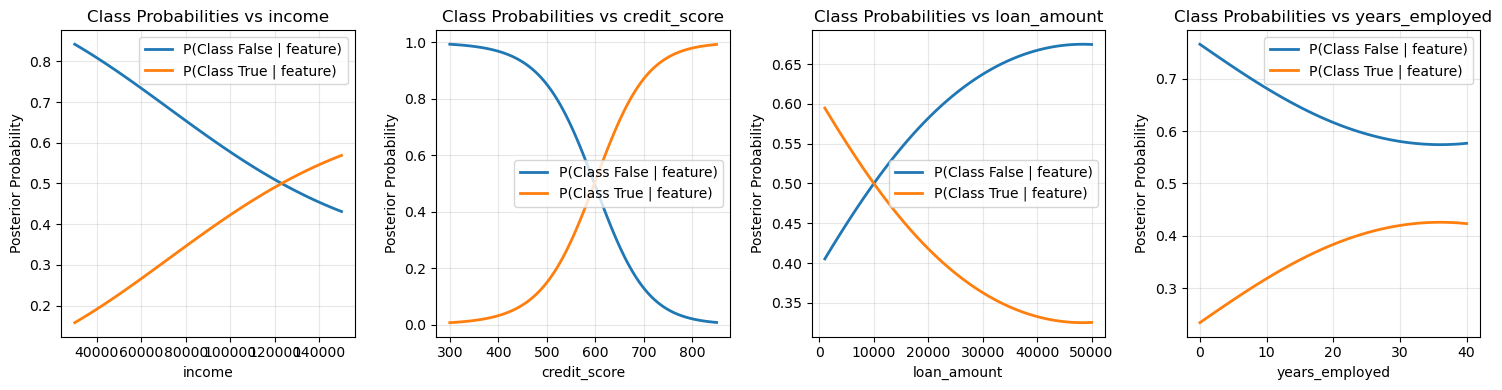

In [6]:
def plot_class_posteriors_by_feature(clf, feature_names, n_features=6):
    """
    Plot how posterior probabilities change with individual feature values
    """
    n_features = min(n_features, len(feature_names))

    n_classes = len(clf.classes_)
    fig, axes = plt.subplots(1, n_features, figsize=(15, 4))
    
    if n_features == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        if i >= len(feature_names):
            break
            
        # Create test values for this feature (keeping others at mean)
        feature_min = X_train.iloc[:, i].min()
        feature_max = X_train.iloc[:, i].max()
        x_range = np.linspace(feature_min, feature_max, 100)
        
        # Create test points
        X_test_single = np.tile(X_train.mean(axis=0), (100, 1))
        X_test_single[:, i] = x_range
        
        # Predict probabilities
        probas = clf.predict_proba(X_test_single)
        
        # Plot posterior probabilities for each class
        for class_idx in range(n_classes):
            ax.plot(x_range, probas[:, class_idx], 
                   label=f'P(Class {clf.classes_[class_idx]} | feature)',
                   linewidth=2)
        
        ax.set_xlabel(f'{feature_names[i]}')
        ax.set_ylabel('Posterior Probability')
        ax.set_title(f'Class Probabilities vs {feature_names[i]}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot class posteriors
plot_class_posteriors_by_feature(clf, feature_names)

In [9]:
def print_parameters(clf, feature_names):
    """
    Print the learned parameters for each feature and class
    """
    print("Learned Parameters for Gaussian Naive Bayes:")
    print("=" * 50)
    
    for class_idx, class_label in enumerate(clf.classes_):
        print(f"\nClass {class_label}:")
        print(f"Prior probability: {clf.class_prior_[class_idx]:.4f}")
        for feature_idx, feature_name in enumerate(feature_names):
            mean = clf.theta_[class_idx, feature_idx]
            std = np.sqrt(clf.var_[class_idx, feature_idx])
            print(f"  {feature_name}: μ = {mean:.3f}, σ = {std:.3f}")

# Print parameters
print_parameters(clf, feature_names)

Learned Parameters for Gaussian Naive Bayes:

Class False:
Prior probability: 0.5606
  income: μ = 82527.957, σ = 34339.648
  credit_score: μ = 471.008, σ = 109.522
  loan_amount: μ = 27209.918, σ = 13461.882
  years_employed: μ = 19.266, σ = 12.108

Class True:
Prior probability: 0.4394
  income: μ = 100179.394, σ = 32005.074
  credit_score: μ = 702.168, σ = 116.514
  loan_amount: μ = 22559.275, σ = 14869.246
  years_employed: μ = 22.060, σ = 11.055


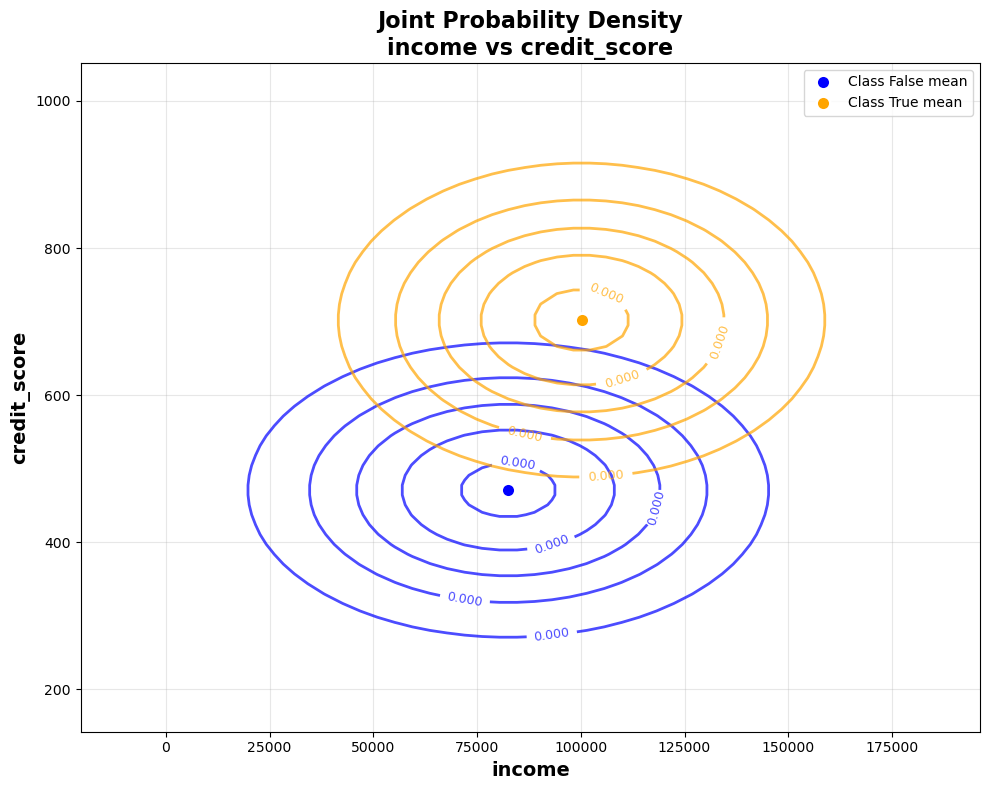

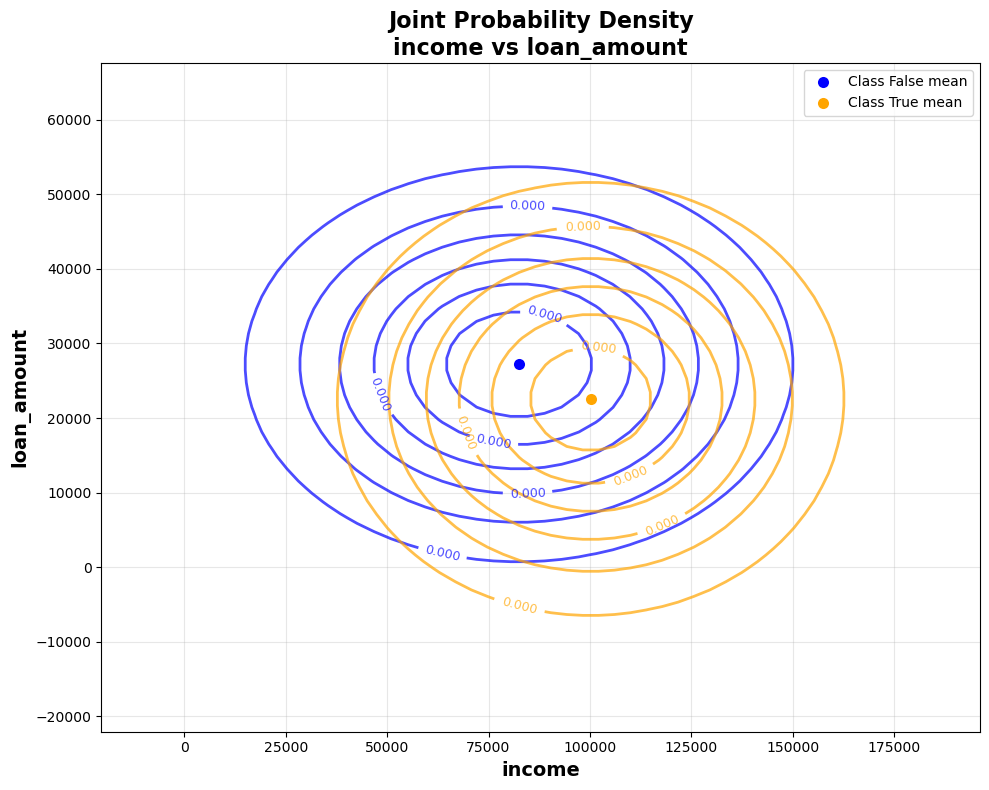

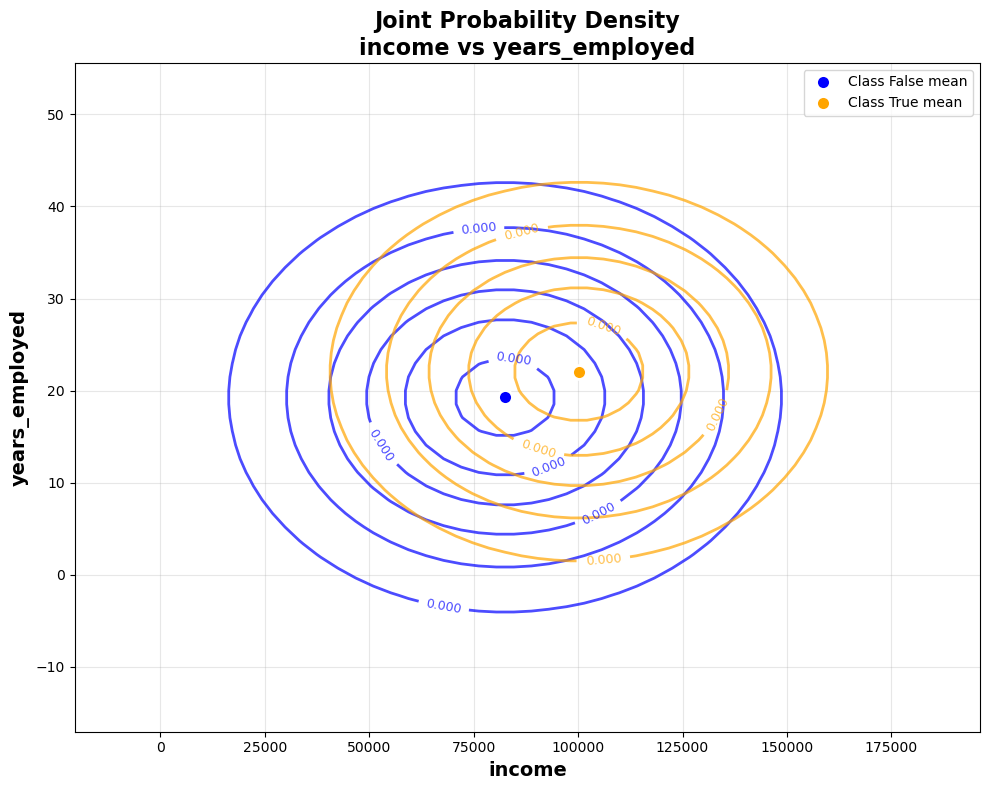

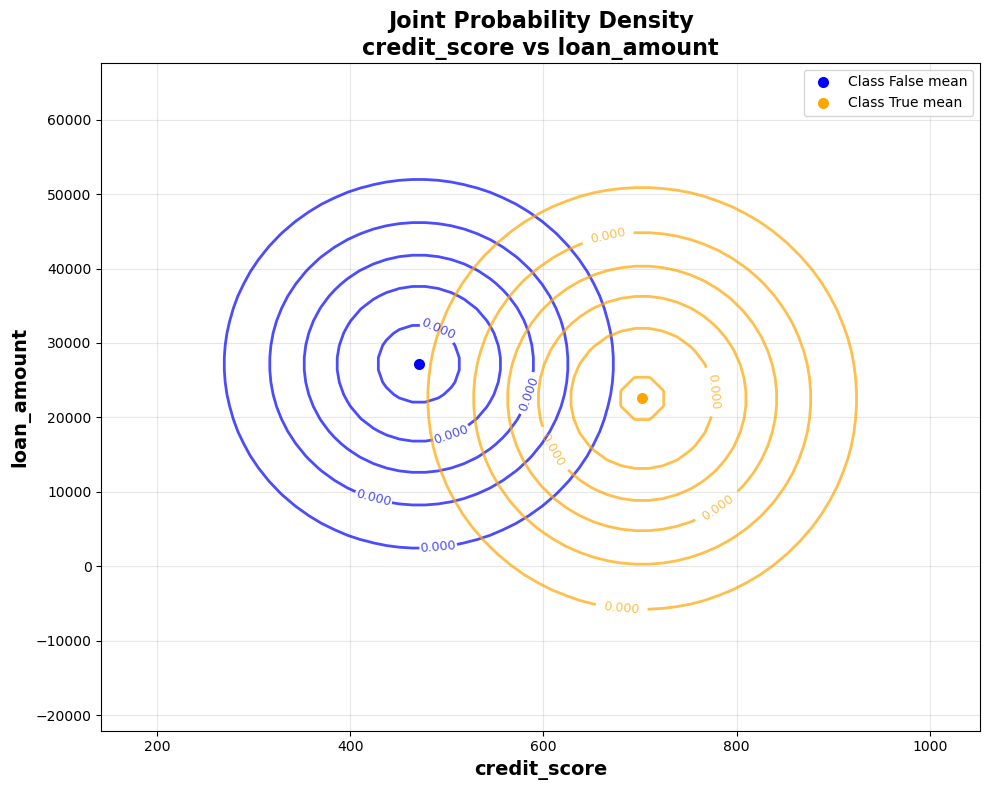

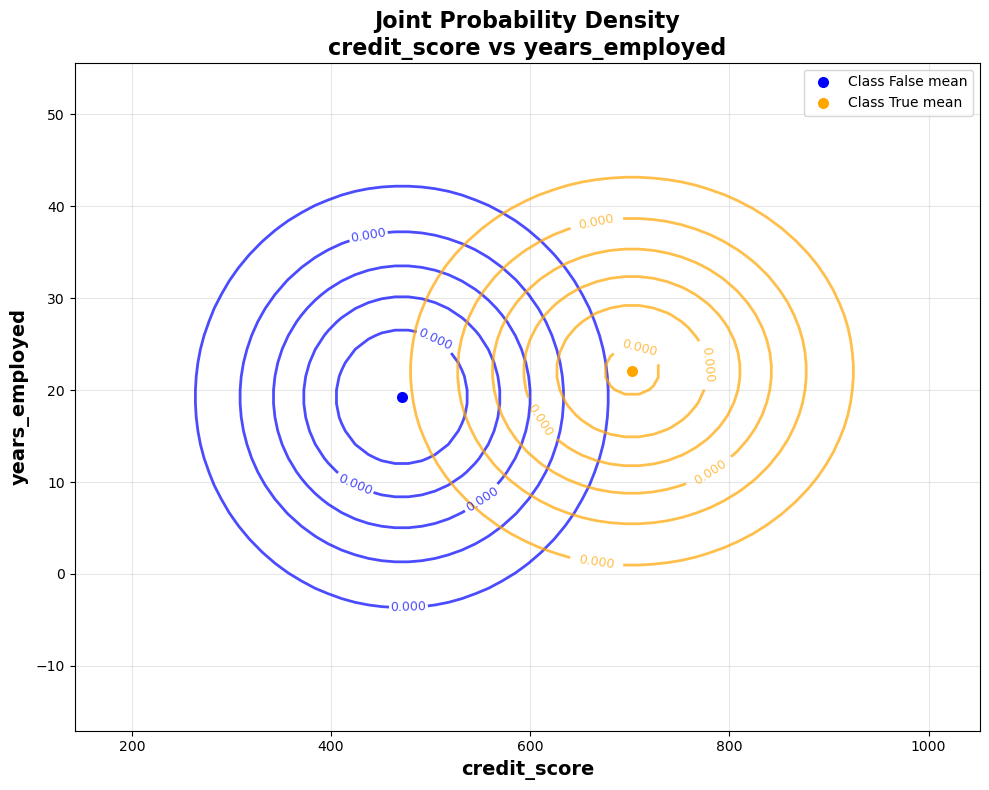

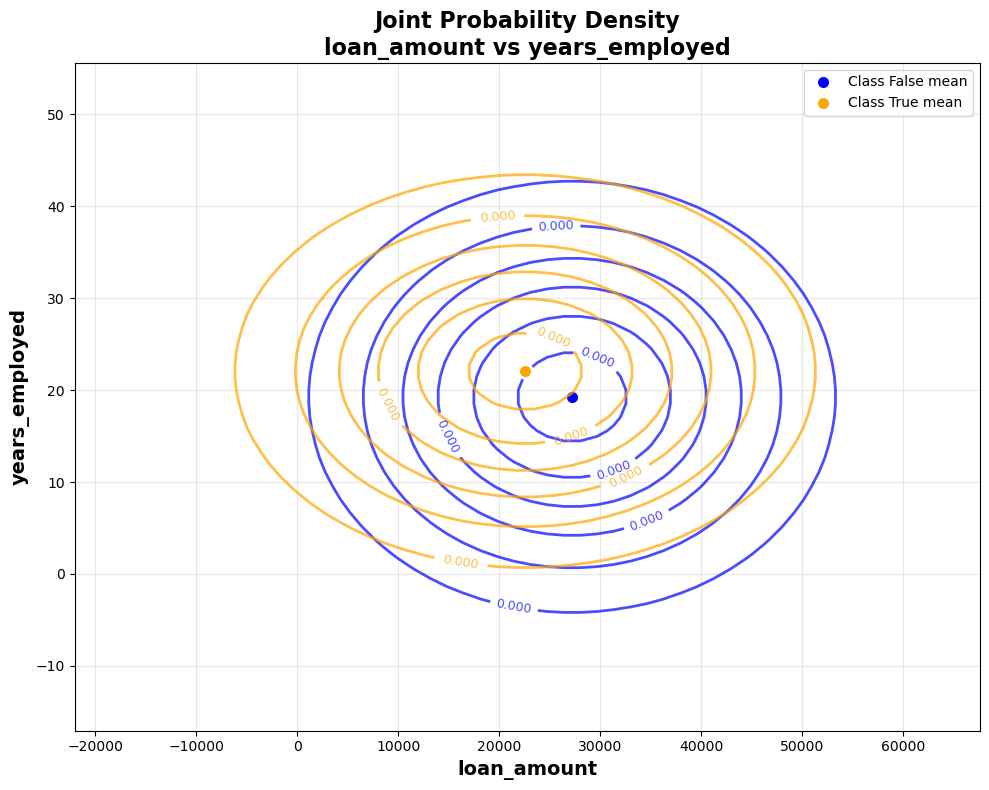

In [8]:
def plot_contours_simple(clf, feature_names, feat1_idx, feat2_idx):
    """Plot joint probability contours P(x_i, x_j | y)"""
    
    means = clf.theta_
    variances = clf.var_
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    for class_idx in range(2):
        mean1 = means[class_idx, feat1_idx]
        mean2 = means[class_idx, feat2_idx]
        var1 = variances[class_idx, feat1_idx]
        var2 = variances[class_idx, feat2_idx]
        std1, std2 = np.sqrt(var1), np.sqrt(var2)
        
        # Create grid
        x_min, x_max = mean1 - 3*std1, mean1 + 3*std1
        y_min, y_max = mean2 - 3*std2, mean2 + 3*std2
        x = np.linspace(x_min, x_max, 50)
        y = np.linspace(y_min, y_max, 50)
        X, Y = np.meshgrid(x, y)
        
        # Calculate joint probability
        prob1 = norm.pdf(X, mean1, std1)
        prob2 = norm.pdf(Y, mean2, std2)
        joint_prob = prob1 * prob2
        
        # Plot contours
        color = ['blue', 'orange'][class_idx]
        contour = ax.contour(X, Y, joint_prob, levels=6, colors=[color], 
                           alpha=0.7, linewidths=2)
        ax.clabel(contour, inline=True, fontsize=9, fmt='%.3f')
        
        # Mark mean
        ax.plot(mean1, mean2, 'o', color=color, markersize=10,
               markeredgecolor='white', markeredgewidth=2,
               label=f'Class {clf.classes_[class_idx]} mean')
    
    ax.set_xlabel(feature_names[feat1_idx], fontweight='bold', fontsize=14)
    ax.set_ylabel(feature_names[feat2_idx], fontweight='bold', fontsize=14)
    ax.set_title(f'Joint Probability Density\n{feature_names[feat1_idx]} vs {feature_names[feat2_idx]}', 
                fontweight='bold', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    return fig


_ = plot_contours_simple(clf, feature_names, feat1_idx=0, feat2_idx=1)
_ = plot_contours_simple(clf, feature_names, feat1_idx=0, feat2_idx=2)
_ = plot_contours_simple(clf, feature_names, feat1_idx=0, feat2_idx=3)
_ = plot_contours_simple(clf, feature_names, feat1_idx=1, feat2_idx=2)
_ = plot_contours_simple(clf, feature_names, feat1_idx=1, feat2_idx=3)
_ = plot_contours_simple(clf, feature_names, feat1_idx=2, feat2_idx=3)
